### Project Goal

You belong to the data team at a local research hospital. You've been tasked with
developing a means to help doctors diagnose breast cancer. You've been given data
about biopsied breast cells; where it is benign (not harmful) or malignant (cancerous).
1. What features of a cell are the largest drivers of malignancy?

Uniformity of Cell Size

2. How would a physician use your product?

3. There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

Depends on how the hospital toloerates false positive rates. But using top five features ['Uniformity of Cell Size','Uniformity of Cell Shape',
              'Bare Nuclei','Bland Chromatin], we can get as high recall score as using all 9 features

# Part 0 Load packages, load data

In [1]:
#import neccessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)   
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

In [2]:
df = pd.read_csv('breast-cancer-wisconsin.txt')
df.head()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


# Part 1: Data Exploration

### 1.1. Understand the raw dataset

In [3]:
print ("Num of rows: " + str(df.shape[0])) # row count
print ("Num of columns: " + str(df.shape[1])) # col count

Num of rows: 15855
Num of columns: 12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15855 non-null int64
ID                             15855 non-null int64
Clump Thickness                15855 non-null int64
Uniformity of Cell Size        15827 non-null object
Uniformity of Cell Shape       15827 non-null object
Marginal Adhesion              15827 non-null object
Single Epithelial Cell Size    15827 non-null object
Bare Nuclei                    15827 non-null object
Bland Chromatin                15827 non-null object
Normal Nucleoli                15827 non-null object
Mitoses                        15827 non-null object
Class                          15827 non-null object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB


In [5]:
# convert to numeric
df = (df.drop(df.columns, axis=1).join(df[df.columns].apply(pd.to_numeric, errors='coerce')))

### 1.2. Understand the target
Class: (2 for benign, 4 for malignant)

In [6]:
df.Class.value_counts()

4.000     15164
2.000       456
40.000      151
20.000        5
Name: Class, dtype: int64

40, 20 might be typo; I will double check

In [7]:
# look at 40 and 20
df[df['Class'].isin([20, 40])].describe()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,156.000,156.000,156.000,156.000,156.000,156.000,156.000,156.000,156.000,156.000,156.000,156.000
mean,7765.545,10372448.782,75.833,65.897,53.077,51.474,42.500,60.833,45.705,49.103,18.462,39.359
std,4529.521,2478915.888,20.477,24.961,20.052,28.188,21.750,32.784,18.841,27.763,17.966,3.534
min,167.000,3782750.000,10.000,10.000,10.000,10.000,20.000,10.000,10.000,10.000,10.000,20.000
25%,3533.250,10763520.000,70.000,50.000,40.000,30.000,30.000,30.000,30.000,30.000,10.000,40.000
50%,8004.500,11112490.000,70.000,60.000,50.000,40.000,40.000,60.000,35.000,50.000,10.000,40.000
75%,11814.500,11986410.000,100.000,90.000,60.000,70.000,40.000,100.000,70.000,70.000,20.000,40.000
max,15841.000,12760910.000,100.000,100.000,100.000,100.000,100.000,100.000,70.000,100.000,70.000,40.000


Yep, these rows have values multipled by 10. I'll divide the data columns by 10 for these rows. We'll also convert benign to 0 and malignant to 1.

In [8]:
# divide by 10
indices = df.index[df['Class'].isin([20, 40])]
df.loc[indices,2:] = df.iloc[:,2:][df['Class'].isin([20, 40])].div(10)

# convert to 0 and 1
df['Class'] = df['Class'].replace(2,0).replace(4,1)

In [9]:
print(df.shape)

(15855, 12)


### 1.3.  Understand the features

In [10]:
# check missing values
df.isnull().sum()

Index                           0
ID                              0
Clump Thickness                 0
Uniformity of Cell Size        79
Uniformity of Cell Shape       79
Marginal Adhesion              79
Single Epithelial Cell Size    79
Bare Nuclei                    95
Bland Chromatin                79
Normal Nucleoli                79
Mitoses                        79
Class                          79
dtype: int64

In [11]:
# drop missing values
df.dropna(inplace=True)

In [12]:
df.describe()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,15760.000,15760.000,15760.000,15760.000,15760.000,15760.000,15760.000,15760.000,15760.000,15760.000,15760.000,15760.000
mean,7926.936,1126044.509,7.587,6.894,5.622,5.035,4.221,6.463,4.614,4.972,1.666,0.972
std,4575.338,995346.649,2.163,2.466,2.130,2.910,2.097,3.222,1.896,2.817,1.506,0.166
min,0.000,63375.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000
25%,3965.750,1076352.000,7.000,5.000,4.000,3.000,3.000,3.000,3.000,3.000,1.000,1.000
50%,7927.500,1111249.000,8.000,6.000,5.000,4.000,4.000,8.000,4.000,5.000,1.000,1.000
75%,11889.250,1198641.000,10.000,10.000,7.000,7.000,4.000,10.000,7.000,8.000,2.000,1.000
max,15854.000,13454352.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,1.000


All features are now within the range of [1,10]

In [13]:
# check the unique values for each column
df.nunique()

Index                          15760
ID                               650
Clump Thickness                   10
Uniformity of Cell Size           10
Uniformity of Cell Shape          10
Marginal Adhesion                 10
Single Epithelial Cell Size       10
Bare Nuclei                       10
Bland Chromatin                   10
Normal Nucleoli                   10
Mitoses                            9
Class                              2
dtype: int64

In [14]:
# understand ID
df.ID.value_counts()

1142706     999
1226612     998
378275      998
1107684     998
1112209     997
1076352     997
1200892     997
1169049     996
1106829     996
691628      995
1241035     995
1198641     994
601265      994
1110524     994
1111249     993
11690490     16
12410350     13
6916280      13
11112490     13
11076840     11
12266120     10
12008920      9
6012650       9
3782750       9
11986410      8
11105240      8
11427060      8
10763520      8
11068290      7
11122090      7
1182404       6
1276091       5
734111        2
385103        2
560680        2
1100524       2
1299596       2
897471        2
1143978       2
1168736       2
798429        2
1240603       2
704097        2
822829        2
1116116       2
1033078       2
1320077       2
493452        2
1116192       2
1218860       2
1158247       2
1238777       2
1299924       2
654546        2
1171710       2
320675        2
1017023       2
1174057       2
1354840       2
1070935       2
1061990       2
695091        2
1293439 

In [15]:
# examine one ID
df[df['ID']==1142706].head()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
4,4,1142706,5.000,10.000,10.000,10.000,6.000,10.000,6.000,5.000,2.000,1.000
7,7,1142706,5.000,10.000,10.000,10.000,6.000,10.000,6.000,5.000,2.000,1.000
51,51,1142706,5.000,10.000,10.000,10.000,6.000,10.000,6.000,5.000,2.000,1.000
54,54,1142706,5.000,10.000,10.000,10.000,6.000,10.000,6.000,5.000,2.000,1.000
56,56,1142706,5.000,10.000,10.000,10.000,6.000,10.000,6.000,5.000,2.000,1.000


These look like duplicates!!! 

In [16]:
# drop index column
df.drop('Index',inplace=True,axis=1)

In [17]:
# keep first duplicate row
original = len(df)
df = df.drop_duplicates()
print('Number of duplicated rows removed:', original - len(df))

Number of duplicated rows removed: 15066


In [18]:
df.drop('ID', inplace=True, axis=1)

In [19]:
df.shape

(694, 10)

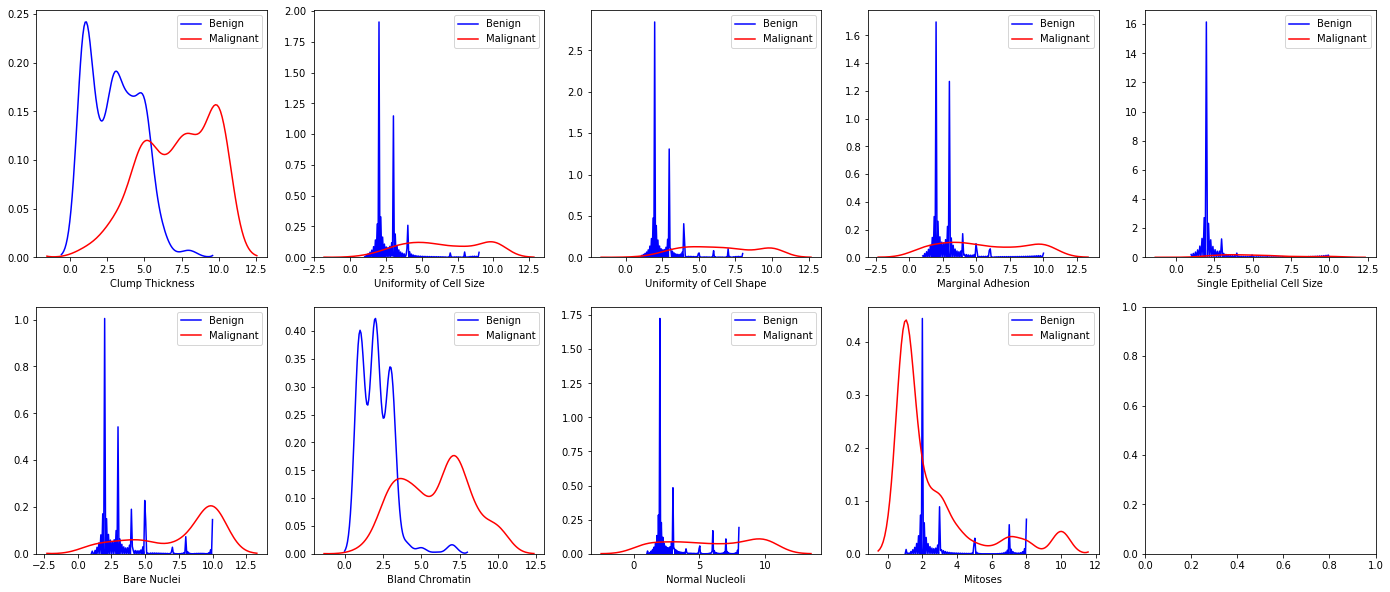

In [20]:
# kernal density plot for each feature

fig, axs = plt.subplots(2,5, figsize=(24,10))
for i, ax in enumerate(fig.axes[:-1]):
    sns.distplot(df.iloc[:,i][df['Class']==0], hist=False, kde=True, color='blue', ax=ax, label='Benign')
    sns.distplot(df.iloc[:,i][df['Class']==1], hist=False, kde=True, color='red', ax=ax, label='Malignant')
    legend = ax.legend()
 

This is encouraging. For most features, there are large differences in the distributions for benign and malignant cells, which suggests that we should have a strong ability to classify them. Some of the most important features appear to be uniformity of cell size and shape because they have very little overlap for benign and malignant cells. . The least important feature appears to be mitoses.

# Part 2: Feature Preprocessing

In [21]:
# Get target variable
y = df['Class']

# check malignant rate
print('malignant rate' + str(y.sum() / y.shape * 100))  
print(df.Class.value_counts())

malignant rate[36.31123919]
0.000    442
1.000    252
Name: Class, dtype: int64


In [22]:
# Get feature space 
X = df.drop('Class', axis=1)

# Part 3: Model Training and Result Evaluation

### 3.1. Split dataset

In [23]:
# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 555 observation with 9 features
test data has 139 observation with 9 features


### 3.2. Model Training and Selection

This is a classification problem, as we want to detect whether the cell is benign or malignant.I will build RF model because features are more like ordinal data. From 1-10, doesn't mean the corresponding observed value is changing linearly. RF mainly care about the ordinal information. It used ensemble learning for reducing model variances. It also has feature importance for feature selection. 

I will evaluate the model performace based on recall. We would want a recall near 1.0,because we are interested in detecting maglinant cells. We want all maglinant cells be detected. We don't want patients that have cancer being not diagnosed. We can accept a low precision if the cost of the follow-up examination is not significant. If testing cost is a concern, then precision is also important.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Random Forest
classifier_RF = RandomForestClassifier()

# fit the model with data
classifier_RF.fit(X_train, y_train)
pred = classifier_RF.predict(X_test)

# model evaluation
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

y_test_prob = classifier_RF.predict_proba(X_test)[::,1]
print("ROC score:",metrics.roc_auc_score(pred, y_test_prob))


Accuracy: 0.9568345323741008
Precision: 0.9534883720930233
Recall: 0.9111111111111111
ROC score: 1.0


In [25]:
importances = classifier_RF.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), X.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
Uniformity of Cell Shape: 0.2461
Uniformity of Cell Size: 0.1951
Bare Nuclei: 0.1672
Bland Chromatin: 0.1295
Single Epithelial Cell Size: 0.1001
Normal Nucleoli: 0.0727
Clump Thickness: 0.0536
Marginal Adhesion: 0.0263
Mitoses: 0.0092


Insights: RF model shows that the top important factor affecting maglinant is Uniformity of Cell Size.


# Part 4. Model Evaluation

In [28]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

cfm = confusion_matrix(y_test,pred)
print(cfm)

[[92  2]
 [ 4 41]]


Text(33.0, 0.5, 'True')

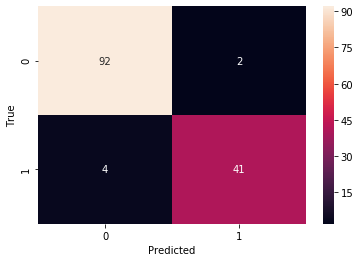

In [29]:
# plot confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, pred))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [30]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        94
         1.0       0.95      0.91      0.93        45

    accuracy                           0.96       139
   macro avg       0.96      0.94      0.95       139
weighted avg       0.96      0.96      0.96       139



My model works really well. It has 0.91 recall on maglinant cases, which means that of all the mglinant cases, my model can detect 91% of them.However, I want to achieve a recall score=1

# Part 5. Can we use fewer features?

In [35]:
# choose some features, not all, for training.
def cm_report(feature_cols):
    print(feature_cols)
    x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df['Class'], test_size=0.33, random_state=24, stratify=df['Class'])
    model = RandomForestClassifier(n_estimators=100, max_depth=None, oob_score=True, random_state=24, max_features='auto')
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)[:,1]
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

In [36]:
select_features = ['Uniformity of Cell Size']
cm_report(select_features)

['Uniformity of Cell Size']
[[142   4]
 [ 18  66]]
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       146
         1.0       0.94      0.79      0.86        84

    accuracy                           0.90       230
   macro avg       0.92      0.88      0.89       230
weighted avg       0.91      0.90      0.90       230



In [38]:
select_features = ['Uniformity of Cell Size', 'Uniformity of Cell Size','Bare Nuclei']
cm_report(select_features)

['Uniformity of Cell Size', 'Uniformity of Cell Size', 'Bare Nuclei']
[[143   3]
 [  8  76]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       146
         1.0       0.96      0.90      0.93        84

    accuracy                           0.95       230
   macro avg       0.95      0.94      0.95       230
weighted avg       0.95      0.95      0.95       230



We can get as high recall score by using 3 features instead of all features

# Prediction analysis on all features model

In [41]:
model_prediction = pd.DataFrame({'pred': pred, 
                                 'prob': y_test_prob,
                                'label': y_test})
model_prediction

,pred,prob,label
11678,1.000,0.950,1.000
9120,0.000,0.000,0.000
932,0.000,0.000,0.000
6163,0.000,0.000,0.000
8456,0.000,0.000,0.000
1634,0.000,0.000,0.000
13233,0.000,0.000,0.000
12299,0.000,0.000,0.000
12030,0.000,0.000,0.000
9744,1.000,1.000,1.000


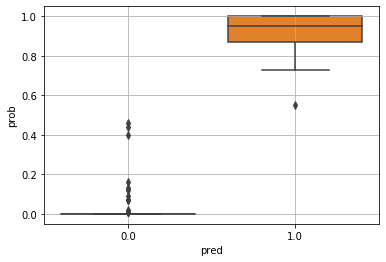

In [42]:
# predicted labels and predicted probability

ax = sns.boxplot(x='pred', y='prob', data=model_prediction)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

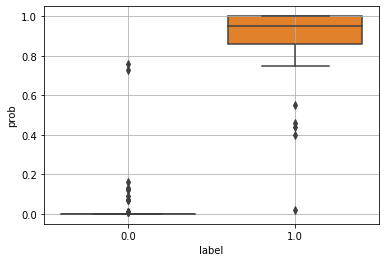

In [43]:
# target labels and predicted prob
ax = sns.boxplot(x='label', y='prob', data=model_prediction)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

In [46]:
x_test_analysis = X_test.copy()
x_test_analysis['label'] = y_test
x_test_analysis['pred'] = pred
x_test_analysis['prob'] = y_test_prob
# x_test_analysis['test_pred'] = y_test_prob

In [47]:
x_test_analysis[x_test_analysis['label'] != x_test_analysis['pred']].sort_values(by='label')

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,label,pred,prob
6609,3.000,4.000,5.000,3.000,7.000,3.000,4.000,6.000,1.000,0.000,1.000,0.730
15756,6.000,8.000,8.000,1.000,3.000,4.000,3.000,7.000,1.000,0.000,1.000,0.760
5622,2.000,3.000,4.000,4.000,2.000,5.000,2.000,5.000,1.000,1.000,0.000,0.460
6451,4.000,1.000,1.000,3.000,1.000,5.000,2.000,1.000,1.000,1.000,0.000,0.020
5214,6.000,3.000,4.000,1.000,5.000,2.000,3.000,9.000,1.000,1.000,0.000,0.400
9432,10.000,2.000,2.000,1.000,2.000,6.000,1.000,1.000,2.000,1.000,0.000,0.440


### If the probability threshold is set to 0.3 (not 0.5)

In [64]:
x_test_analysis['threshold_pred'] = x_test_analysis['prob'].apply(lambda x: 1 if x > 0.3 else 0)

In [65]:
print(confusion_matrix(y_test, x_test_analysis['threshold_pred']))
print(classification_report(y_test, x_test_analysis['threshold_pred']))

[[92  2]
 [ 1 44]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        94
         1.0       0.96      0.98      0.97        45

    accuracy                           0.98       139
   macro avg       0.97      0.98      0.98       139
weighted avg       0.98      0.98      0.98       139



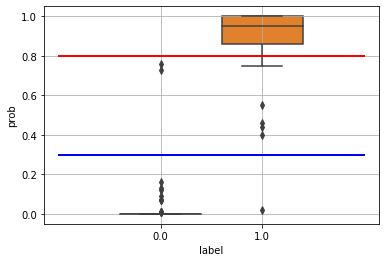

In [66]:
ax = sns.boxplot(x='label', y='prob', data=model_prediction)
ax.plot([-1,2], [0.3,0.3], lw=2, color='b')
ax.plot([-1,2], [0.8,0.8], lw=2, color='r')
ax.yaxis.grid(True)
ax.xaxis.grid(True)

Comment:
- If the predicted probability is larger than 0.3. Then the patient should be notified that the probability for malignant is very high, 95%.
- If the predicted probability is larger than 0.8, the patient and doctor should pay serious attention to this case.
- If the predicted probability is between 0.3 - 0.8, the patient should be considerd for malignant cancer but further observations are still need for more convincing conclusions.